In [76]:
import cv2
import rasterio
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
from pathlib import Path
import albumentations as A
from rasterio.plot import reshape_as_image
from torch.utils.data import Dataset
from torchvision import transforms

class SegmentDataset(Dataset):
    def __init__(self, 
                 image_path: Path, 
                 mask_path: Path, 
                 patch_size: int,
                 transform: A.Compose = None):
        super().__init__()
        self.image_path = image_path
        self.mask_path = mask_path
        self.patch_size = patch_size
        self.transform = transform
 
        with rasterio.open(str(self.image_path), 'r', driver='JP2OpenJPEG') as src:
                self.image_raster = src.read()

        with rasterio.open(str(self.mask_path), 'r', driver='JP2OpenJPEG') as src:
                self.mask_raster = src.read()

        if self.image_raster[0].shape == self.mask_raster[0].shape:
            self.width = self.image_raster.shape[1]
            self.height = self.image_raster.shape[2]

            self.images = self.make_patches(self.image_raster)
            self.masks = self.make_patches(self.mask_raster)
        
    def make_patches(self, raster: np.array):
        if self.patch_size is None:
            raise ValueError('You must specify patch size.')
            
        slices = []    
        for h_cord in np.arange(start=self.patch_size, 
                                stop=self.height + 1, 
                                step=self.patch_size):
            for w_cord in np.arange(start=self.patch_size, 
                                    stop=self.width + 1, 
                                    step=self.patch_size):
                slices.append(reshape_as_image(raster[:, 
                               h_cord - self.patch_size: h_cord, 
                               w_cord - self.patch_size: w_cord]))
        return slices
    
    def save_patches(self, path_to_save:Path):
        tqd = tqdm(enumerate(zip(self.images, self.masks), start = 1))
        for i, (image, mask) in tqd:
            img_path = (path_to_save / str(self.patch_size) / 'images')
            img_path.mkdir(exist_ok=True, parents=True)
            
            mask_path = (path_to_save / str(self.patch_size) / 'masks')
            mask_path.mkdir(exist_ok=True, parents=True)
            
            cv2.imwrite(str(img_path / f'{i}.jpg'), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
            cv2.imwrite(str(mask_path / f'{i}.jpg'), mask)
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        image = self.images[idx]
        mask = self.masks[idx]
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            
        return image, mask

In [82]:
image_path = Path('data/raw/image.jp2')
mask_path = Path('data/raw/mask.jp2')
cashe_path = Path('data')

transform = A.Compose([
    A.RandomCrop(width=128, height=128),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

dataset = SegmentDataset(image_path, mask_path, 256 ,transform=transform)

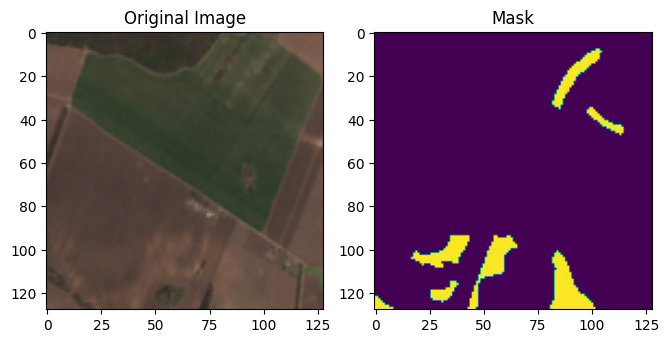

In [103]:
import matplotlib.pyplot as plt
# create a new figure
fig = plt.figure(figsize=(10, 5))
org, mask = next(iter(dataset))

# add the original image subplot to the figure
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(org)
ax1.set_title('Original Image')

# add the mask subplot to the figure
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(mask)
ax2.set_title('Mask')

# adjust the spacing between subplots
fig.tight_layout()

# show the figure
plt.show()